In [51]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

import matplotlib.pyplot as plt
import pandas as pd
import umap.umap_ as umap
import plotly.express as px
import numpy as np
import os
import plotly.graph_objects as go

In [85]:
def z_score(X):
    # X: ndarray, shape (n_features, n_samples)
    # ss = StandardScaler(with_mean=True, with_std=True)
    # ss = RobustScaler()
    ss = MaxAbsScaler()
    Xz = ss.fit_transform(X)
    return Xz

In [86]:
d = pd.read_csv(r"neuralData_cross_validation.csv")
data = d.dropna()
allGoodCol = data.columns
allGoodCol = list(allGoodCol)
allGoodCol = allGoodCol[4::]

# nbRUN1 = len(data[data["exposure"] == 1]["lap"].unique())
# nbRUN2 = len(data[data["exposure"] == 2]["lap"].unique())

# print("Number of neurons : ", len(allGoodCol))
# print("Nb of lap of the 1st exposure is", nbRUN1)
# print("Nb of lap of the 2nd exposure is", nbRUN2)

# meanLength = int(np.mean([len(data[data["lap"] == i]) for i in range(1, data["lap"].max() + 1)]))

# # We can reduce the number of laps in RUN2 to 16
# # print("Cropping RUN2 to 16 laps")
# # data = data[data['lap'] < len(data[data["exposure"] == 1]["lap"].unique()) + 16]
# # print("Number of laps :", len(data["lap"].unique()))

# # We reduce the number of lab in RUN2 to the same as in RUN1 to avoid any bias
# print("Cropping RUN2 to RUN1 length")
# data = data[data['lap'] < 2*nbRUN1 + 1]

parsedData = data[allGoodCol].values

In [87]:
pca = PCA(n_components=20, svd_solver='full')
# pca = FastICA(n_components=3, random_state=0, whiten='unit-variance')
# pca = KernelPCA(n_components=3, kernel="cosine")

pca_embedding = pca.fit_transform(z_score(parsedData))
pca_embedding = pca_embedding[:,0:3]

df = pd.DataFrame(pca_embedding, columns=['x1', 'x2', 'x3'])
df["x"] = data.x
df["lap"] = data.lap
# df["exposure"] = data.exposure

fig = px.scatter_3d(df, x='x1', y='x2', z='x3', color='x', opacity=0.9, title="PCA")
fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

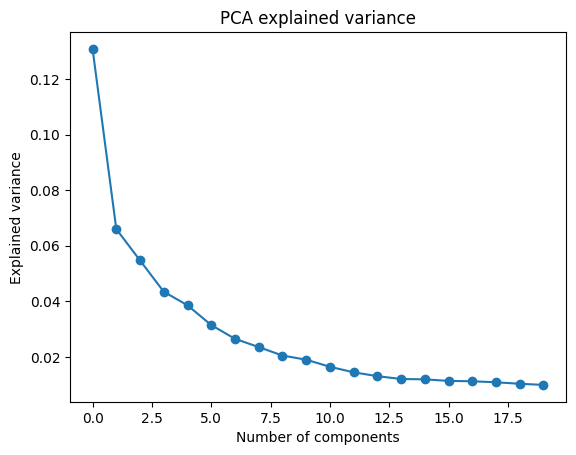

In [88]:
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.title("PCA explained variance")
plt.show()

In [89]:
# For this one, we need to make every trial the same length with interpolation

print("Mean length: ", meanLength)

interpolatedData = np.zeros((meanLength, 3, data["lap"].max()))
interpolatedPos = np.zeros((meanLength, (data["lap"].max())))

for i in range(1, data["lap"].max() + 1):

    posData = data[data["lap"] == i]

    lapData = pca_embedding[data["lap"] == i, :]

    durationTrial = len(lapData)
    timeVector = [(1/durationTrial) * i for i in range(0, durationTrial)]
    goalVector = [(1/meanLength) * i for i in range(0, meanLength)]
    positionVector = posData["x"]

    if durationTrial != meanLength:
        newDataMat = np.zeros((meanLength, 3))
        interpPos = np.interp(goalVector, timeVector, positionVector)
        for d in range(0, 3):
            neuralData = lapData[:, d]
            interpVector = np.interp(goalVector, timeVector, neuralData)
            newDataMat[:, d] = interpVector
    else:
        newDataMat = lapData

    interpolatedData[:, :, i - 1] = newDataMat
    interpolatedPos[:, i - 1] = interpPos

Mean length:  60


In [90]:
# We're taking the lap-to-lap mean euclinidian distance between the two runs

meanDist = np.zeros((data["lap"].max(), 1))
for i in range(1, data["lap"].max()):
    meanDist[i] = np.median(np.linalg.norm(interpolatedData[:, :, i] - interpolatedData[:, :, i - 1], axis=1))

In [91]:
# Now that we have our main trajectories, we can project SWR data in the space

# Load the replay data - MAKE SURE IT'S THE SAME ANIMAL !

dRep = pd.read_csv(r"replayData.csv")
dataRep = dRep.dropna()
allGoodColRep = dataRep.columns
allGoodColRep = list(allGoodColRep)
allGoodColRep = allGoodColRep[3::]

parsedDataRep = dataRep[allGoodCol].values
embeddingRep = pca.transform(parsedDataRep)

KeyError: "['c7', 'c19', 'c76', 'c77', 'c81', 'c83', 'c88', 'c89', 'c90', 'c91', 'c92', 'c93', 'c122', 'c125', 'c126', 'c128', 'c129', 'c145', 'c148', 'c150', 'c153', 'c157', 'c160', 'c161'] not in index"

In [ ]:
fig = go.Figure(data=[go.Scatter3d(x= df["x1"], y= df["x2"], z = df["x3"], mode='markers')])

fig.add_trace(go.Scatter3d(x=embeddingRep[:, 0], y=embeddingRep[:, 1], z=embeddingRep[:, 2], mode='markers'))

fig.update_traces(marker_size=2)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

#### The projection of replay in PCA components seems bad